In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [15]:
conn = sqlite3.connect('../data/final_data.db')
cursor = conn.cursor()

In [28]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
table_names = [table[0] for table in tables]
print('Tables in the database:', table_names)

if len(table_names) == 2:
    print('Confirmed: Database contains exactly 2 tables')
else:
    print(f'Expected 2 tables, but found {len(table_names)} tables.')

for table_name in table_names:
    print(f"\nContents of table '{table_name}':")
    query = f'SELECT * FROM {table_name} LIMIT 5'
    df =  pd.read_sql_query(query, conn)
    print(df)

Tables in the database: ['vehicle_prices', 'fatalities']
Confirmed: Database contains exactly 2 tables

Contents of table 'vehicle_prices':
   year  Light_Trucks_Sold  Passenger_Cars_Sold
0  1994                 43                  243
1  1995                 92                  391
2  1996                114                  448
3  1997                251                  791
4  1998                322                 1142

Contents of table 'fatalities':
   Fatalities_Year  Passenger_Cars  Light_Trucks  Large_Trucks  Motorcycles  \
0             2015           19810         18869          4075         5131   
1             2014           17895         17160          3749         4707   
2             2013           17957         16928          3921         4800   
3             2012           18269         17350          3825         5113   
4             2011           17508         16806          3633         4769   

   Buses  Other/Unknown  Total  
0    263           1330  49478 

Setting up a query funtion that will take a string

In [29]:
def query(query: str):
    return pd.read_sql(query, conn)

In [30]:
all = """SELECT * FROM fatalities LIMIT 5"""
query(all)

,Fatalities_Year,Passenger_Cars,Light_Trucks,Large_Trucks,Motorcycles,Buses,Other/Unknown,Total
0,2015,19810,18869,4075,5131,263,1330,49478
1,2014,17895,17160,3749,4707,236,1205,44950
2,2013,17957,16928,3921,4800,282,1213,45101
3,2012,18269,17350,3825,5113,253,1150,45960
4,2011,17508,16806,3633,4769,245,1158,44119


In [31]:
more = """SELECT * FROM vehicle_prices LIMIT 5"""
query(more)

,year,Light_Trucks_Sold,Passenger_Cars_Sold
0,1994,43,243
1,1995,92,391
2,1996,114,448
3,1997,251,791
4,1998,322,1142


In [71]:
joined_query = """
SELECT *
FROM vehicle_prices
LEFT JOIN fatalities
ON fatalities.Fatalities_Year = vehicle_prices.year;
"""
joined_df = query(joined_query)
print(joined_df)

    year  Light_Trucks_Sold  Passenger_Cars_Sold  Fatalities_Year  \
0   1994                 43                  243             1994   
1   1995                 92                  391             1995   
2   1996                114                  448             1996   
3   1997                251                  791             1997   
4   1998                322                 1142             1998   
5   1999                652                 1575             1999   
6   2000               1021                 2406             2000   
7   2001               1957                 3183             2001   
8   2002               3204                 4489             2002   
9   2003               4603                 5765             2003   
10  2004               6972                 6652             2004   
11  2005               8463                 8706             2005   
12  2006               9631                12000             2006   
13  2007              12013       

Saving the joined table as a dataframe so I can make plots.

In [39]:
joined_df.to_sql('joined', conn, if_exists='replace', index=False)

22

Selecting the specific columns that I want to examine from my joined table and saving that query as its own data frame.

In [42]:
main_selection = """
SELECT year, Light_Trucks_Sold, Passenger_Cars_Sold, Passenger_Cars, Light_Trucks
FROM joined;
"""
main_selection_df = query(main_selection)

In [43]:
main_selection_df.to_sql('main_selection', conn, if_exists='replace', index=False)

22

Calculating the total fatalities in passenger cars

In [44]:
fatal_car = main_selection_df['Passenger_Cars'].sum()
print(fatal_car)

534487


Calculating the total fatalities in light trucks

In [46]:
fatal_truck = main_selection_df['Light_Trucks'].sum()
print(fatal_truck)

426844


Creating the pie chart to compare fatalities in passenger vehicles with those in light trucks.

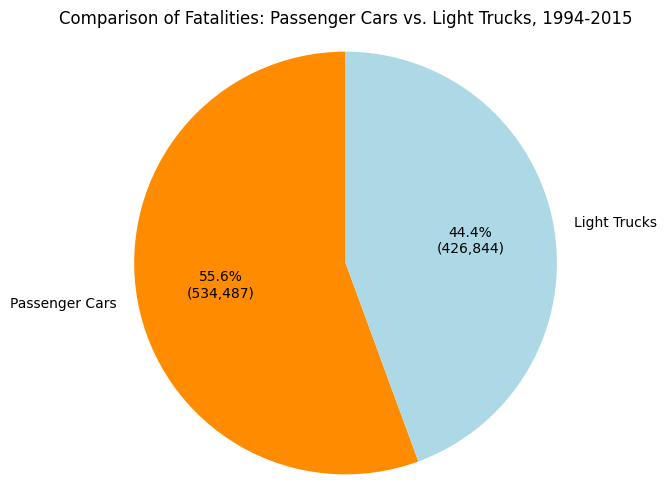

In [56]:
plt.figure(figsize=(6, 6))
plt.pie(
    [fatal_car, fatal_truck],
    labels=['Passenger Cars', 'Light Trucks'],
    autopct=lambda pct: f'{pct:.1f}%\n({int(round(pct * sum([fatal_car, fatal_truck]) / 100.0)):,})',
    startangle=90,
    colors=['darkorange', 'lightblue']
)
plt.title('Comparison of Fatalities: Passenger Cars vs. Light Trucks, 1994-2015')
plt.axis('equal')

plt.show()

Creating a scatter plot to show the fatalities over time based on vehicle type.

In [81]:
year = main_selection_df['year']
fatal_car = main_selection_df['Passenger_Cars']
fatal_truck = main_selection_df['Light_Trucks']

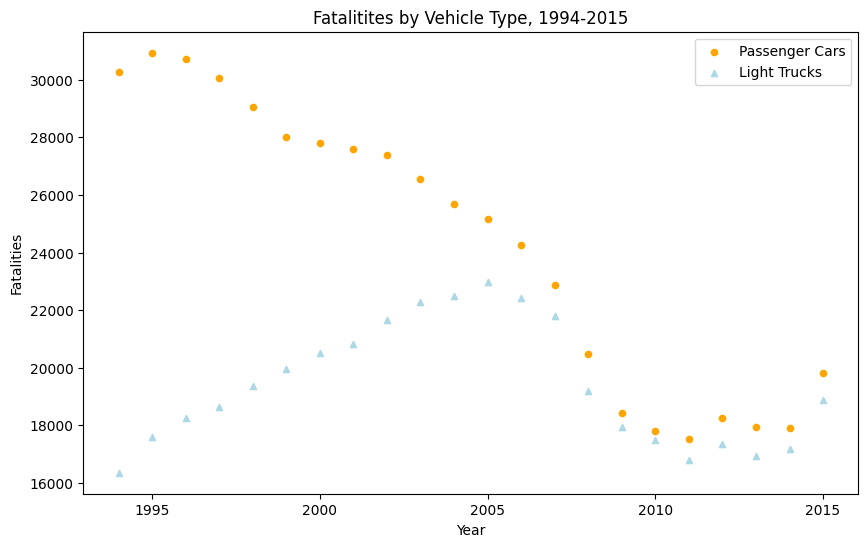

In [83]:
plt.figure(figsize=(10,6))
plt.scatter(year, fatal_car, color='orange', label='Passenger Cars', marker='o', s=20)
plt.scatter(year, fatal_truck, color='lightblue', label='Light Trucks', marker='^', s=20)
plt.title('Fatalitites by Vehicle Type, 1994-2015')
plt.xlabel('Year')
plt.ylabel('Fatalities')
plt.legend()
plt.show()


Creating a bar chart showing the fatalities by vehicel type over time

In [68]:
year = main_selection_df['year']
passenger_cars = main_selection_df['Passenger_Cars']
light_trucks = main_selection_df['Light_Trucks']

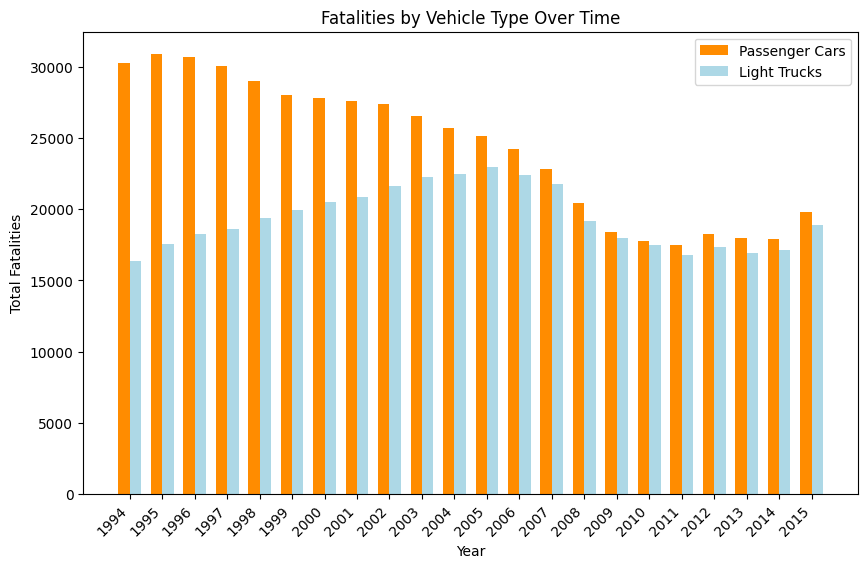

In [69]:
plt.figure(figsize=(10,6))
bar_width = 0.35
x=np.arange(len(year))
plt.bar(x - bar_width/2, passenger_cars, bar_width, label = 'Passenger Cars', color='darkorange')
plt.bar(x + bar_width/2, light_trucks, bar_width, label='Light Trucks', color='lightblue')
plt.title('Fatalities by Vehicle Type Over Time')
plt.xlabel('Year')
plt.ylabel('Total Fatalities')
plt.xticks(x, year, rotation=45, ha='right')
plt.legend()
plt.show()

Creating a bar chart to compare the number of each type of vehicle sold by year.

In [73]:
cars_sold = joined_df['Passenger_Cars_Sold'].sum()
print(cars_sold)

283964


In [75]:
trucks_sold = joined_df['Light_Trucks_Sold'].sum()
print(trucks_sold)

188053


In [79]:
year = joined_df['year']
cars = joined_df['Passenger_Cars_Sold']
trucks = joined_df['Light_Trucks_Sold']


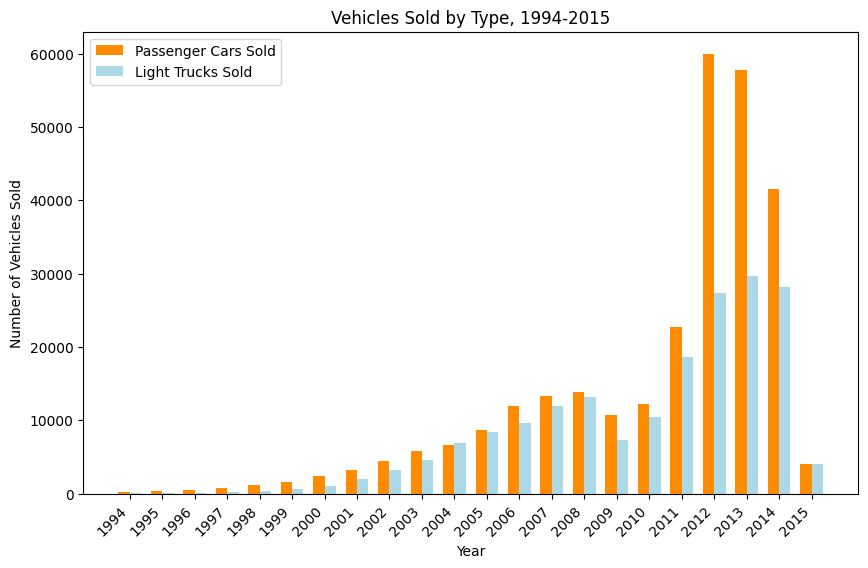

In [80]:
plt.figure(figsize=(10,6))
bar_width = 0.35
x=np.arange(len(year))
plt.bar(x - bar_width/2, cars, bar_width, label = 'Passenger Cars Sold', color='darkorange')
plt.bar(x + bar_width/2, trucks, bar_width, label='Light Trucks Sold', color='lightblue')
plt.title('Vehicles Sold by Type, 1994-2015')
plt.xlabel('Year')
plt.ylabel('Number of Vehicles Sold')
plt.xticks(x, year, rotation=45, ha='right')
plt.legend()
plt.show()